# **Install Dependencies**

In [3]:
# 📦 Install dependencies
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install -q pycocotools

# 🔧 Setup: Import
import os
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import random
import cv2
from matplotlib import pyplot as plt

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-6v5u6adu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-6v5u6adu
  Resolved https://github.com/facebookresearch/detectron2.git to commit 65184fc057d4fab080a98564f6b60fae0b94edc4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.2 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6438581 sha256=c5609d8efacf741deea62685ac94417db70413306ce787c57069c819d1d76d30
  Stored in directory: /tmp/pip-ephem-wheel-cache-yv37ayvi/wheels/17/d9/40/60db98e485aa9455d

# **Register Dataset**

In [6]:
# Set root folder di Google Drive
dataset_root = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new"

# Buat path lengkap ke JSON dan folder gambar
train_json = os.path.join(dataset_root, "train/_annotations.coco.json")
val_json = os.path.join(dataset_root, "valid/_annotations.coco.json")
test_json = os.path.join(dataset_root, "test/_annotations.coco.json")
train_img_dir = os.path.join(dataset_root, "train")
val_img_dir = os.path.join(dataset_root, "valid")
test_img_dir = os.path.join(dataset_root, "test")

# ✅ Cek apakah file dan folder ada
print("Train JSON exists:", os.path.exists(train_json))
print("Train Image Dir exists:", os.path.exists(train_img_dir))

# 🗂 Daftarkan dataset ke Detectron2
register_coco_instances("roboflow_train", {}, train_json, train_img_dir)
register_coco_instances("roboflow_val", {}, val_json, val_img_dir)
register_coco_instances("roboflow_test", {}, test_json, test_img_dir)

Train JSON exists: True
Train Image Dir exists: True


# Epoch 30_1e-3

In [ ]:
from detectron2 import model_zoo

# ⚙️ Konfigurasi RetinaNet
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("roboflow_train",)
cfg.DATASETS.TEST = ("roboflow_val",)
cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.001  # Untuk Adam, bisa 1e-3 – 1e-4
cfg.SOLVER.MAX_ITER = 1680  # Ubah sesuai jumlah data dan epoch yang diinginkan
cfg.SOLVER.STEPS = []  # Jangan gunakan step scheduler untuk Adam
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.WEIGHT_DECAY_BIAS = 0.0
cfg.SOLVER.WEIGHT_DECAY_NORM = 0.0  # Tambahan penting

cfg.TEST.EVAL_PERIOD = 500  # Evaluasi setiap 500 iterasi
cfg.MODEL.RETINANET.NUM_CLASSES = 4  # Jumlah kelas sebenarnya (tanpa background)

# 📂 Output directory
cfg.OUTPUT_DIR = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-3_Adam"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
from detectron2.engine.hooks import BestCheckpointer
from detectron2.evaluation import COCOEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultTrainer
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.events import EventStorage

import torch

# 🧠 Custom Trainer class
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

    @classmethod
    def build_optimizer(cls, cfg, model):
        """
        Override default SGD optimizer with Adam
        """
        params = []
        for name, param in model.named_parameters():
            if not param.requires_grad:
                continue
            lr = cfg.SOLVER.BASE_LR
            if "bias" in name:
                weight_decay = cfg.SOLVER.WEIGHT_DECAY_BIAS
            elif "norm" in name:
                weight_decay = cfg.SOLVER.WEIGHT_DECAY_NORM  # Tambahkan decay norm
            else:
                weight_decay = cfg.SOLVER.WEIGHT_DECAY
            params.append({"params": [param], "lr": lr, "weight_decay": weight_decay})

        optimizer = torch.optim.Adam(params, lr=cfg.SOLVER.BASE_LR)
        return optimizer

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(
            -1,
            BestCheckpointer(
                cfg.TEST.EVAL_PERIOD,
                checkpointer=DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                val_metric="bbox/AP",
                mode="max",
                file_prefix="best_model"
            )
        )
        return hooks

# Inisialisasi trainer dan mulai training
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/14 14:00:11 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
R-50.pkl: 102MB [00:00, 138MB/s]                            


[06/14 14:00:13 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[06/14 14:00:13 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 54


backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
backbone.top_block.p6.{bias, weight}
backbone.top_block.p7.{bias, weight}
head.bbox_pred.{bias, weight}
head.bbox_subnet.0.{bias, weight}
head.bbox_subnet.2.{bias, weight}
head.bbox_subnet.4.{bias, weight}
head.bbox_subnet.6.{bias, weight}
head.cls_score.{bias, weight}
head.cls_subnet.0.{bias, weight}
head.cls_subnet.2.{bias, weight}
head.cls_subnet.4.{bias, weight}
head.cls_subnet.6.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


[06/14 14:00:13 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/14 14:01:12 d2.utils.events]:  eta: 1:11:01  iter: 19  total_loss: 2.449  loss_cls: 1.491  loss_box_reg: 1.004    time: 2.7515  last_time: 2.5286  data_time: 0.8799  last_data_time: 0.5980   lr: 1.9981e-05  max_mem: 7611M
[06/14 14:02:10 d2.utils.events]:  eta: 1:11:40  iter: 39  total_loss: 1.572  loss_cls: 0.9428  loss_box_reg: 0.6767    time: 2.7064  last_time: 2.6546  data_time: 0.6734  last_data_time: 0.5971   lr: 3.9961e-05  max_mem: 7611M
[06/14 14:03:05 d2.utils.events]:  eta: 1:11:57  iter: 59  total_loss: 1.455  loss_cls: 0.8382  loss_box_reg: 0.6148    time: 2.7242  last_time: 2.3815  data_time: 0.5968  last_data_time: 0.1894   lr: 5.9941e-05  max_mem: 7611M
[06/14 14:03:52 d2.utils.events]:  eta: 1:08:57  iter: 79  total_loss: 1.416  loss_cls: 0.795  loss_box_reg: 0.6101    time: 2.6311  last_time: 2.5018  data_time: 0.2093  last_data_time: 0.3487   lr: 7.9921e-05  max_mem: 7611M
[06/14 14:04:40 d2.utils.events]:  eta: 1:06:34  iter: 99  total_loss: 1.436  loss_cls: 0.8

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/14 14:19:54 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0024 s/iter. Inference: 0.0830 s/iter. Eval: 0.0001 s/iter. Total: 0.0855 s/iter. ETA=0:00:08
[06/14 14:20:01 d2.evaluation.evaluator]: Inference done 52/111. Dataloading: 0.0824 s/iter. Inference: 0.0749 s/iter. Eval: 0.0001 s/iter. Total: 0.1575 s/iter. ETA=0:00:09
[06/14 14:20:06 d2.evaluation.evaluator]: Total inference time: 0:00:11.996061 (0.113170 s / iter per device, on 1 devices)
[06/14 14:20:06 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.074262 s / iter per device, on 1 devices)
[06/14 14:20:06 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/14 14:20:06 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-3_Adam/inference/coco_instances_results.json
[06/14 14:20:06 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
WARNING [06/14 14:

KeyboardInterrupt: 

# Epoch 30_1e-5

In [7]:
from detectron2 import model_zoo

# ⚙️ Konfigurasi RetinaNet
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("roboflow_train",)
cfg.DATASETS.TEST = ("roboflow_val",)
cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.00001
cfg.SOLVER.MAX_ITER = 1680  # Ubah sesuai jumlah data dan epoch yang diinginkan
cfg.SOLVER.STEPS = []  # Jangan gunakan step scheduler untuk Adam
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.WEIGHT_DECAY_BIAS = 0.0
# cfg.SOLVER.WEIGHT_DECAY_NORM = 0.0  # Tambahan penting

cfg.TEST.EVAL_PERIOD = 500  # Evaluasi setiap 500 iterasi
cfg.MODEL.RETINANET.NUM_CLASSES = 4  # Jumlah kelas sebenarnya (tanpa background)

# 📂 Output directory
cfg.OUTPUT_DIR = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
from detectron2.engine.hooks import BestCheckpointer
from detectron2.evaluation import COCOEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultTrainer
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.events import EventStorage

import torch

# 🧠 Custom Trainer class
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

    @classmethod
    def build_optimizer(cls, cfg, model):
        """
        Override default SGD optimizer with Adam
        """
        params = []
        for name, param in model.named_parameters():
            if not param.requires_grad:
                continue
            lr = cfg.SOLVER.BASE_LR
            if "bias" in name:
                weight_decay = cfg.SOLVER.WEIGHT_DECAY_BIAS
            elif "norm" in name:
                weight_decay = cfg.SOLVER.WEIGHT_DECAY_NORM  # Tambahkan decay norm
            else:
                weight_decay = cfg.SOLVER.WEIGHT_DECAY
            params.append({"params": [param], "lr": lr, "weight_decay": weight_decay})

        optimizer = torch.optim.Adam(params, lr=cfg.SOLVER.BASE_LR)
        return optimizer

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(
            -1,
            BestCheckpointer(
                cfg.TEST.EVAL_PERIOD,
                checkpointer=DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                val_metric="bbox/AP",
                mode="max",
                file_prefix="best_model"
            )
        )
        return hooks

# Inisialisasi trainer dan mulai training
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/15 02:49:02 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
R-50.pkl: 102MB [00:00, 252MB/s]                           

[06/15 02:49:03 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......


[06/15 02:49:03 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 54


backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
backbone.top_block.p6.{bias, weight}
backbone.top_block.p7.{bias, weight}
head.bbox_pred.{bias, weight}
head.bbox_subnet.0.{bias, weight}
head.bbox_subnet.2.{bias, weight}
head.bbox_subnet.4.{bias, weight}
head.bbox_subnet.6.{bias, weight}
head.cls_score.{bias, weight}
head.cls_subnet.0.{bias, weight}
head.cls_subnet.2.{bias, weight}
head.cls_subnet.4.{bias, weight}
head.cls_subnet.6.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


[06/15 02:49:04 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/15 02:50:22 d2.utils.events]:  eta: 1:40:29  iter: 19  total_loss: 2.468  loss_cls: 1.537  loss_box_reg: 0.9618    time: 3.6913  last_time: 3.6436  data_time: 1.8097  last_data_time: 1.6985   lr: 1.9981e-07  max_mem: 7608M
[06/15 02:51:42 d2.utils.events]:  eta: 1:40:32  iter: 39  total_loss: 1.823  loss_cls: 1.125  loss_box_reg: 0.7201    time: 3.7045  last_time: 3.7112  data_time: 1.7140  last_data_time: 1.6764   lr: 3.9961e-07  max_mem: 7608M
[06/15 02:52:51 d2.utils.events]:  eta: 1:39:37  iter: 59  total_loss: 1.91  loss_cls: 1.159  loss_box_reg: 0.7346    time: 3.6204  last_time: 2.4823  data_time: 1.4287  last_data_time: 0.3742   lr: 5.9941e-07  max_mem: 7608M
[06/15 02:53:37 d2.utils.events]:  eta: 1:36:55  iter: 79  total_loss: 1.851  loss_cls: 1.132  loss_box_reg: 0.7293    time: 3.2796  last_time: 2.2649  data_time: 0.2486  last_data_time: 0.2347   lr: 7.9921e-07  max_mem: 7608M
[06/15 02:54:22 d2.utils.events]:  eta: 1:33:46  iter: 99  total_loss: 1.897  loss_cls: 1.134

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/15 03:09:44 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.1462 s/iter. Inference: 0.0721 s/iter. Eval: 0.0004 s/iter. Total: 0.2187 s/iter. ETA=0:00:21
[06/15 03:09:49 d2.evaluation.evaluator]: Inference done 35/111. Dataloading: 0.1399 s/iter. Inference: 0.0722 s/iter. Eval: 0.0004 s/iter. Total: 0.2126 s/iter. ETA=0:00:16
[06/15 03:09:54 d2.evaluation.evaluator]: Inference done 61/111. Dataloading: 0.1322 s/iter. Inference: 0.0721 s/iter. Eval: 0.0004 s/iter. Total: 0.2047 s/iter. ETA=0:00:10
[06/15 03:09:59 d2.evaluation.evaluator]: Inference done 85/111. Dataloading: 0.1274 s/iter. Inference: 0.0721 s/iter. Eval: 0.0079 s/iter. Total: 0.2076 s/iter. ETA=0:00:05
[06/15 03:10:04 d2.evaluation.evaluator]: Inference done 109/111. Dataloading: 0.1298 s/iter. Inference: 0.0718 s/iter. Eval: 0.0062 s/iter. Total: 0.2078 s/iter. ETA=0:00:00
[06/15 03:10:05 d2.evaluation.evaluator]: Total inference time: 0:00:22.332326 (0.210682 s / iter per device, on 1 devices)
[06/1

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/15 03:29:13 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0012 s/iter. Inference: 0.0735 s/iter. Eval: 0.0003 s/iter. Total: 0.0749 s/iter. ETA=0:00:07
[06/15 03:29:18 d2.evaluation.evaluator]: Inference done 78/111. Dataloading: 0.0014 s/iter. Inference: 0.0736 s/iter. Eval: 0.0003 s/iter. Total: 0.0754 s/iter. ETA=0:00:02
[06/15 03:29:21 d2.evaluation.evaluator]: Total inference time: 0:00:08.169849 (0.077074 s / iter per device, on 1 devices)
[06/15 03:29:21 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.073792 s / iter per device, on 1 devices)
[06/15 03:29:21 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/15 03:29:21 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/inference/coco_instances_results.json
[06/15 03:29:21 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and prepar

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/15 03:48:34 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0049 s/iter. Inference: 0.0780 s/iter. Eval: 0.0005 s/iter. Total: 0.0833 s/iter. ETA=0:00:08
[06/15 03:48:39 d2.evaluation.evaluator]: Inference done 77/111. Dataloading: 0.0021 s/iter. Inference: 0.0744 s/iter. Eval: 0.0004 s/iter. Total: 0.0770 s/iter. ETA=0:00:02
[06/15 03:48:42 d2.evaluation.evaluator]: Total inference time: 0:00:08.177758 (0.077149 s / iter per device, on 1 devices)
[06/15 03:48:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.073964 s / iter per device, on 1 devices)
[06/15 03:48:42 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/15 03:48:42 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/inference/coco_instances_results.json
[06/15 03:48:42 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and prepar

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/15 03:55:39 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0012 s/iter. Inference: 0.0732 s/iter. Eval: 0.0003 s/iter. Total: 0.0747 s/iter. ETA=0:00:07
[06/15 03:55:44 d2.evaluation.evaluator]: Inference done 77/111. Dataloading: 0.0019 s/iter. Inference: 0.0736 s/iter. Eval: 0.0003 s/iter. Total: 0.0759 s/iter. ETA=0:00:02
[06/15 03:55:47 d2.evaluation.evaluator]: Total inference time: 0:00:08.160231 (0.076983 s / iter per device, on 1 devices)
[06/15 03:55:47 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.073903 s / iter per device, on 1 devices)
[06/15 03:55:47 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/15 03:55:47 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/inference/coco_instances_results.json
[06/15 03:55:47 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and prepar

**Save Konfigurasi**

In [ ]:
with open(os.path.join(cfg.OUTPUT_DIR, "config.yaml"), "w") as f:
    f.write(cfg.dump())

**Test Prediksi**

[06/15 03:56:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/best_model.pth ...


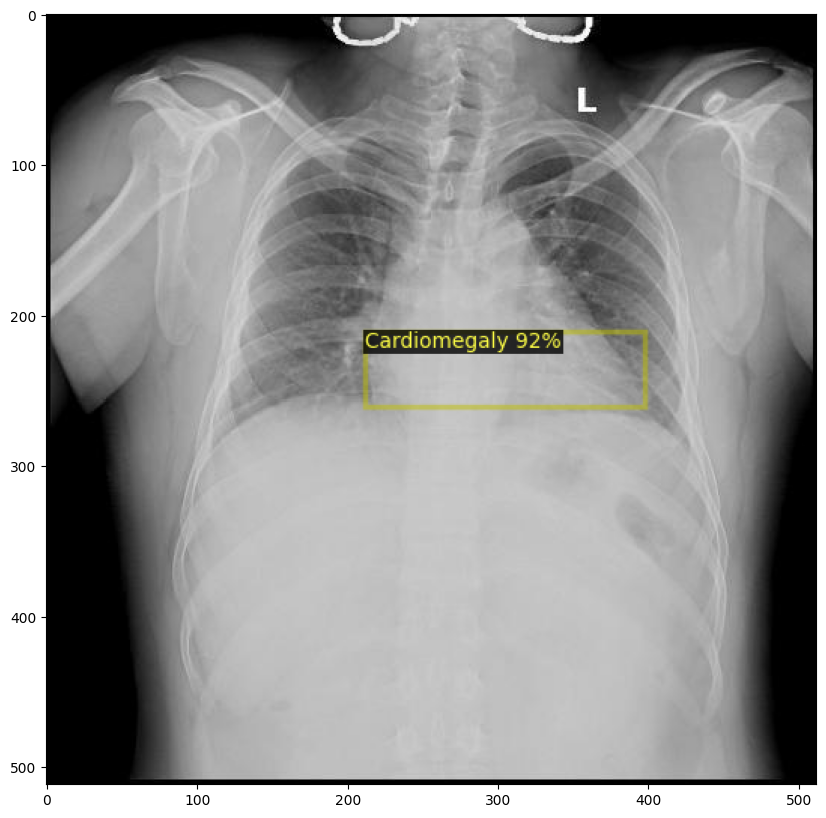

Detected 1 objects with confidence > 50.0%.


In [ ]:
# 🧠 Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "best_model.pth")  # Load the weights from your training
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold to 50% for detection

from detectron2.engine import DefaultPredictor

predictor = DefaultPredictor(cfg)

# 📸 Read the image
#image_path = '/content/valid/00000732_005_jpg.rf.3541c4c659fec2d5d003b4fb7a380dea.jpg'
image_path = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/test/9ed1f91369552618456da255b02820b3_jpg.rf.17cd671024249e0b1f3a9e36be41a928.jpg"
im = cv2.imread(image_path)

# 🧠 Run inference
outputs = predictor(im)

# Filter instances with confidence
confidence = 0.5
instances = outputs["instances"]
scores = instances.scores
filtered_instances = instances[scores > confidence]

# 🖼️ Visualize the results
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("roboflow_train"), scale=1)
v = v.draw_instance_predictions(filtered_instances.to("cpu"))

# Show the image with filtered instances
plt.figure(figsize=(10, 10))
plt.imshow(v.get_image())
plt.show()

# Optionally, print out the number of detections
print(f"Detected {len(filtered_instances)} objects with confidence > {confidence*100}%.")


**Confusion Matriks**

In [8]:
def calculate_iou(box1, box2):
    """
    box: [xmin, ymin, xmax, ymax]
    """
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    if union_area == 0:
        return 0
    else:
        return inter_area / union_area


Processing Test Images:   0%|          | 0/111 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Processing Test Images: 100%|██████████| 111/111 [00:13<00:00,  8.47it/s]


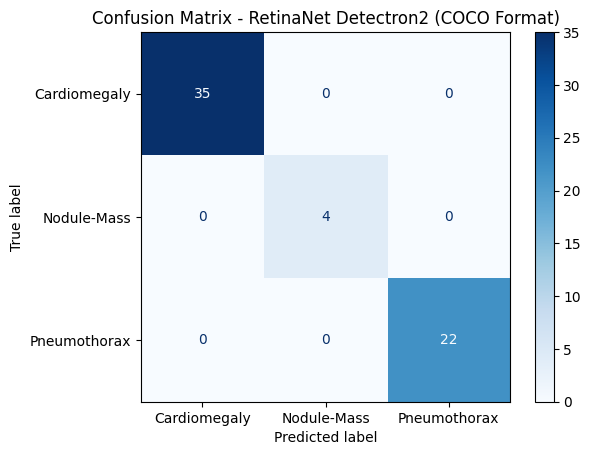

In [9]:
import os
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 🧠 Load model
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "best_model.pth")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/best_model.pth"
predictor = DefaultPredictor(cfg)

# 📚 Prepare dataset paths
test_image_dir = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test"
coco_annotation_path = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test/_annotations.coco.json"

# Load COCO ground truth
with open(coco_annotation_path) as f:
    coco_data = json.load(f)

# Build image_id to filename mapping
id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}

# Build annotations mapping
annotations = coco_data['annotations']
gt_dict = {}  # {filename: (boxes, labels)}

for ann in annotations:
    image_id = ann['image_id']
    filename = id_to_filename[image_id]
    bbox = ann['bbox']  # [x, y, width, height]
    category_id = ann['category_id']

    if filename not in gt_dict:
        gt_dict[filename] = {'boxes': [], 'labels': []}

    # Convert bbox format to [xmin, ymin, xmax, ymax]
    xmin, ymin, w, h = bbox
    xmax = xmin + w
    ymax = ymin + h

    gt_dict[filename]['boxes'].append([xmin, ymin, xmax, ymax])
    gt_dict[filename]['labels'].append(category_id)

# Build category_id to class_name mapping
category_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
class_names = [category_id_to_name[i] for i in sorted(category_id_to_name.keys())]

# 🔥 Start evaluating
y_true = []
y_pred = []
iou_threshold = 0.5
confidence_threshold = 0.5

test_images = sorted(os.listdir(test_image_dir))
test_images = [img for img in test_images if img.endswith('.jpg') or img.endswith('.png')]

for img_file in tqdm(test_images, desc="Processing Test Images"):
    # Read image
    img_path = os.path.join(test_image_dir, img_file)
    img = cv2.imread(img_path)

    if img_file not in gt_dict:
        continue  # skip images without ground truth

    gt_boxes = np.array(gt_dict[img_file]['boxes'])
    gt_classes = np.array(gt_dict[img_file]['labels'])

    # Predict
    outputs = predictor(img)
    instances = outputs["instances"].to("cpu")

    pred_boxes = instances.pred_boxes.tensor.numpy()
    pred_classes = instances.pred_classes.numpy()
    pred_scores = instances.scores.numpy()

    # Filter predictions by confidence
    keep = pred_scores > confidence_threshold
    pred_boxes = pred_boxes[keep]
    pred_classes = pred_classes[keep]

    matched_gt = set()

    # Matching predicted boxes to ground truth boxes
    for pred_box, pred_class in zip(pred_boxes, pred_classes):
        best_iou = 0
        best_idx = -1
        for idx, gt_box in enumerate(gt_boxes):
            iou = calculate_iou(pred_box, gt_box)
            if iou > best_iou and idx not in matched_gt:
                best_iou = iou
                best_idx = idx
        if best_iou >= iou_threshold and best_idx != -1:
            y_true.append(gt_classes[best_idx])
            y_pred.append(pred_class)
            matched_gt.add(best_idx)
        else:
            # False positive
            y_true.append(-1)  # background
            y_pred.append(pred_class)

    # False negatives
    for idx, gt_class in enumerate(gt_classes):
        if idx not in matched_gt:
            y_true.append(gt_class)
            y_pred.append(-1)

# 🔥 Build Confusion Matrix
all_labels = sorted(list(set([lab for lab in y_true if lab != -1] + [lab for lab in y_pred if lab != -1])))
cm = confusion_matrix(y_true, y_pred, labels=all_labels)

class_labels = [category_id_to_name[i] for i in all_labels]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - RetinaNet Detectron2 (COCO Format)")
plt.show()


**Evaluasi Data Train**

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

# Load config dan model
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/config.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/best_model.pth"
cfg.MODEL.DEVICE = 'cpu'  # atau 'cpu'
cfg.DATASETS.TEST = ("roboflow_train",)
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

evaluator = COCOEvaluator("roboflow_train", cfg, False, output_dir="/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/eval_train")
val_loader = build_detection_test_loader(cfg, "roboflow_train")

model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

results = inference_on_dataset(model, val_loader, evaluator)
print(results)

WARNING [06/15 03:57:22 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [06/15 03:57:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/15 03:57:22 d2.data.datasets.coco]: Loaded 892 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/train/_annotations.coco.json
[06/15 03:57:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/15 03:57:22 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/15 03:57:22 d2.data.common]: Serializing 892 elements to byte tensors and concatenating them all ...
[06/15 03:57:22 d2.data.common]: Serialized dataset takes 0.30 MiB


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/15 03:57:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/best_model.pth ...
[06/15 03:57:23 d2.evaluation.evaluator]: Start inference on 892 batches
[06/15 03:58:04 d2.evaluation.evaluator]: Inference done 11/892. Dataloading: 0.0014 s/iter. Inference: 3.7339 s/iter. Eval: 0.0002 s/iter. Total: 3.7355 s/iter. ETA=0:54:50
[06/15 03:58:10 d2.evaluation.evaluator]: Inference done 13/892. Dataloading: 0.0015 s/iter. Inference: 3.6062 s/iter. Eval: 0.0002 s/iter. Total: 3.6080 s/iter. ETA=0:52:51
[06/15 03:58:18 d2.evaluation.evaluator]: Inference done 15/892. Dataloading: 0.0016 s/iter. Inference: 3.6463 s/iter. Eval: 0.0002 s/iter. Total: 3.6484 s/iter. ETA=0:53:19
[06/15 03:58:25 d2.evaluation.evaluator]: Inference done 17/892. Dataloading: 0.0024 s/iter. Inference: 3.5833 s/iter. Eval: 0.0002 s/iter. Total: 3.5864 s/iter. ETA=0:52:18
[06/15 03:58:32 d2.evaluation.e

**Evaluasi Data Validasi**

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

# Load config dan model
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/config.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/best_model.pth"
cfg.MODEL.DEVICE = 'cpu'  # atau 'cpu'
cfg.DATASETS.TEST = ("roboflow_val",)
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

evaluator = COCOEvaluator("roboflow_val", cfg, False, output_dir="/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/eval_valid")
val_loader = build_detection_test_loader(cfg, "roboflow_val")

model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

results = inference_on_dataset(model, val_loader, evaluator)
print(results)

WARNING [06/15 04:52:43 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [06/15 04:52:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/15 04:52:43 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/valid/_annotations.coco.json
[06/15 04:52:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/15 04:52:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/15 04:52:43 d2.data.common]: Serializing 111 elements to byte tensors and concatenating them all ...
[06/15 04:52:43 d2.data.common]: Serialized dataset takes 0.04 MiB


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/15 04:52:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/best_model.pth ...
[06/15 04:52:44 d2.evaluation.evaluator]: Start inference on 111 batches
[06/15 04:53:24 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0015 s/iter. Inference: 3.7289 s/iter. Eval: 0.0001 s/iter. Total: 3.7305 s/iter. ETA=0:06:13
[06/15 04:53:30 d2.evaluation.evaluator]: Inference done 13/111. Dataloading: 0.0017 s/iter. Inference: 3.5999 s/iter. Eval: 0.0001 s/iter. Total: 3.6021 s/iter. ETA=0:05:53
[06/15 04:53:39 d2.evaluation.evaluator]: Inference done 15/111. Dataloading: 0.0023 s/iter. Inference: 3.6913 s/iter. Eval: 0.0001 s/iter. Total: 3.6940 s/iter. ETA=0:05:54
[06/15 04:53:45 d2.evaluation.evaluator]: Inference done 17/111. Dataloading: 0.0023 s/iter. Inference: 3.6167 s/iter. Eval: 0.0002 s/iter. Total: 3.6195 s/iter. ETA=0:05:40
[06/15 04:53:53 d2.evaluation.e

**Evaluasi Data Testing**

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

# Load config dan model
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/config.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/best_model.pth"
cfg.MODEL.DEVICE = 'cpu'  # atau 'cpu'
cfg.DATASETS.TEST = ("roboflow_test",)
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

evaluator = COCOEvaluator("roboflow_test", cfg, False, output_dir="/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/eval_test")
val_loader = build_detection_test_loader(cfg, "roboflow_test")

model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

results = inference_on_dataset(model, val_loader, evaluator)
print(results)

WARNING [06/15 05:01:27 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [06/15 05:01:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/15 05:01:28 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test/_annotations.coco.json
[06/15 05:01:28 d2.data.build]: Distribution of instances among all 4 categories:
|   category    | #instances   |   category   | #instances   |  category   | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-----------:|:-------------|
| abnormalities | 0            | Cardiomegaly | 36           | Nodule-Mass | 34           |
| Pneumothorax  | 40           |              |              |             |              |
|     total     | 110          |              |       

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/15 05:01:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/best_model.pth ...
[06/15 05:01:29 d2.evaluation.evaluator]: Start inference on 111 batches
[06/15 05:02:09 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0014 s/iter. Inference: 3.4182 s/iter. Eval: 0.0001 s/iter. Total: 3.4198 s/iter. ETA=0:05:41
[06/15 05:02:15 d2.evaluation.evaluator]: Inference done 13/111. Dataloading: 0.0015 s/iter. Inference: 3.3380 s/iter. Eval: 0.0002 s/iter. Total: 3.3400 s/iter. ETA=0:05:27
[06/15 05:02:23 d2.evaluation.evaluator]: Inference done 15/111. Dataloading: 0.0021 s/iter. Inference: 3.4278 s/iter. Eval: 0.0002 s/iter. Total: 3.4306 s/iter. ETA=0:05:29
[06/15 05:02:29 d2.evaluation.evaluator]: Inference done 17/111. Dataloading: 0.0021 s/iter. Inference: 3.3711 s/iter. Eval: 0.0002 s/iter. Total: 3.3739 s/iter. ETA=0:05:17
[06/15 05:02:36 d2.evaluation.e

**Evaluasi Precision Recall F1-Score**

In [ ]:
from detectron2.evaluation.evaluator import DatasetEvaluator
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

class PRF1Evaluator(DatasetEvaluator):
    def __init__(self, dataset_name, metadata, class_names=None):
        from detectron2.data import MetadataCatalog, DatasetCatalog
        self.metadata = MetadataCatalog.get(dataset_name)
        self.dataset_dicts = DatasetCatalog.get(dataset_name)
        self.class_names = class_names if class_names else self.metadata.thing_classes
        self.gts = []
        self.preds = []

        # Buat mapping image_id ke daftar ground truth class ID
        self.imgid_to_gt = {}
        for data in self.dataset_dicts:
            gt_classes = [ann["category_id"] for ann in data["annotations"]]
            self.imgid_to_gt[data["image_id"]] = gt_classes

    def reset(self):
        self.gts = []
        self.preds = []

    def process(self, inputs, outputs):
        for input, output in zip(inputs, outputs):
            img_id = input["image_id"]
            gt_classes = self.imgid_to_gt.get(img_id, [])
            pred_classes = output["instances"].pred_classes.cpu().numpy() if len(output["instances"]) > 0 else []

            # Samakan panjang prediksi dan ground truth
            if len(pred_classes) < len(gt_classes):
                pred_classes = list(pred_classes) + [-1] * (len(gt_classes) - len(pred_classes))
            elif len(pred_classes) > len(gt_classes):
                pred_classes = pred_classes[:len(gt_classes)]

            self.gts.extend(gt_classes)
            self.preds.extend(pred_classes)

    def evaluate(self):
        print("\n==== Precision, Recall, and F1-Score per Class ====\n")

        # Ambil hasil sebagai dictionary
        report_dict = classification_report(
            self.gts,
            self.preds,
            target_names=self.class_names,
            output_dict=True,
            digits=3,
            zero_division=0
        )

        # Konversi ke DataFrame
        df = pd.DataFrame(report_dict).transpose()
        df.index.name = 'Class'

        # Ambil dan simpan nilai akurasi, hapus dari tabel supaya tampil rapi
        accuracy = report_dict.get("accuracy", None)
        if "accuracy" in df.index:
            df.drop("accuracy", inplace=True)

        # Ubah support menjadi integer
        if 'support' in df.columns:
            df['support'] = df['support'].astype(int)

        # Urutkan kolom
        df = df[['precision', 'recall', 'f1-score', 'support']]

        # Cetak tabel
        print(df.to_string(float_format="%.3f"))

        # Cetak akurasi secara terpisah
        if accuracy is not None:
            print(f"\nOverall Accuracy: {accuracy:.3f}")

        # Return hanya data, tanpa tampilkan dict sebagai output Python
        return


**Data Train**

In [ ]:
class_names = ["Cardiomegaly", "Nodule/Mass", "Pneumothorax"]

evaluator_test = PRF1Evaluator("roboflow_train", cfg, class_names=class_names)
test_loader = build_detection_test_loader(cfg, "roboflow_train")
inference_on_dataset(trainer.model, test_loader, evaluator_test)


WARNING [06/15 05:09:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/15 05:09:19 d2.data.datasets.coco]: Loaded 892 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/train/_annotations.coco.json
WARNING [06/15 05:09:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/15 05:09:19 d2.data.datasets.coco]: Loaded 892 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/train/_annotations.coco.json
[06/15 05:09:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/15 05:09:19 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/15 05:09:19 d2.data.common]: Serializing 892 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/15 05:09:20 d2.evaluation.evaluator]: Inference done 11/892. Dataloading: 0.0011 s/iter. Inference: 0.0722 s/iter. Eval: 0.0001 s/iter. Total: 0.0735 s/iter. ETA=0:01:04
[06/15 05:09:25 d2.evaluation.evaluator]: Inference done 72/892. Dataloading: 0.0058 s/iter. Inference: 0.0757 s/iter. Eval: 0.0001 s/iter. Total: 0.0817 s/iter. ETA=0:01:06
[06/15 05:09:30 d2.evaluation.evaluator]: Inference done 138/892. Dataloading: 0.0040 s/iter. Inference: 0.0747 s/iter. Eval: 0.0001 s/iter. Total: 0.0789 s/iter. ETA=0:00:59
[06/15 05:09:35 d2.evaluation.evaluator]: Inference done 205/892. Dataloading: 0.0033 s/iter. Inference: 0.0744 s/iter. Eval: 0.0001 s/iter. Total: 0.0778 s/iter. ETA=0:00:53
[06/15 05:09:40 d2.evaluation.evaluator]: Inference done 266/892. Dataloading: 0.0039 s/iter. Inference: 0.0748 s/iter. Eval: 0.0001 s/iter. Total: 0.0789 s/iter. ETA=0:00:49
[06/15 05:09:45 d2.evaluation.evaluator]: Inference done 332/892. Dataloading: 0.0034 s/iter. Inference: 0.0747 s/iter. Eval: 0

{}

**Data Validasi**

In [ ]:
class_names = ["Cardiomegaly", "Nodule/Mass", "Pneumothorax"]

evaluator_test = PRF1Evaluator("roboflow_val", cfg, class_names=class_names)
test_loader = build_detection_test_loader(cfg, "roboflow_val")
inference_on_dataset(trainer.model, test_loader, evaluator_test)


WARNING [06/15 05:11:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/15 05:11:25 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/valid/_annotations.coco.json
WARNING [06/15 05:11:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/15 05:11:25 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/valid/_annotations.coco.json
[06/15 05:11:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/15 05:11:25 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/15 05:11:25 d2.data.common]: Serializing 111 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/15 05:11:26 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0011 s/iter. Inference: 0.0725 s/iter. Eval: 0.0001 s/iter. Total: 0.0737 s/iter. ETA=0:00:07
[06/15 05:11:31 d2.evaluation.evaluator]: Inference done 79/111. Dataloading: 0.0015 s/iter. Inference: 0.0726 s/iter. Eval: 0.0001 s/iter. Total: 0.0743 s/iter. ETA=0:00:02
[06/15 05:11:33 d2.evaluation.evaluator]: Total inference time: 0:00:08.008707 (0.075554 s / iter per device, on 1 devices)
[06/15 05:11:33 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.072768 s / iter per device, on 1 devices)

==== Precision, Recall, and F1-Score per Class ====

              precision  recall  f1-score  support
Class                                             
Cardiomegaly      0.521   0.962     0.676       26
Nodule/Mass       1.000   0.250     0.400       28
Pneumothorax      0.946   0.930     0.938       57
macro avg         0.822   0.714     0.671      111
weighted avg      0.860   0.766     0.

{}

**Data Testing**

In [ ]:
class_names = ["Cardiomegaly", "Nodule/Mass", "Pneumothorax"]

evaluator_test = PRF1Evaluator("roboflow_test", cfg, class_names=class_names)
test_loader = build_detection_test_loader(cfg, "roboflow_test")
inference_on_dataset(trainer.model, test_loader, evaluator_test)


WARNING [06/15 05:11:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/15 05:11:38 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test/_annotations.coco.json
WARNING [06/15 05:11:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/15 05:11:38 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test/_annotations.coco.json
[06/15 05:11:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/15 05:11:38 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/15 05:11:38 d2.data.common]: Serializing 111 el

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/15 05:11:39 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0012 s/iter. Inference: 0.0744 s/iter. Eval: 0.0001 s/iter. Total: 0.0757 s/iter. ETA=0:00:07
[06/15 05:11:44 d2.evaluation.evaluator]: Inference done 78/111. Dataloading: 0.0017 s/iter. Inference: 0.0737 s/iter. Eval: 0.0001 s/iter. Total: 0.0755 s/iter. ETA=0:00:02
[06/15 05:11:47 d2.evaluation.evaluator]: Total inference time: 0:00:08.237353 (0.077711 s / iter per device, on 1 devices)
[06/15 05:11:47 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.074089 s / iter per device, on 1 devices)

==== Precision, Recall, and F1-Score per Class ====

              precision  recall  f1-score  support
Class                                             
Cardiomegaly      0.600   1.000     0.750       36
Nodule/Mass       0.929   0.382     0.542       34
Pneumothorax      0.889   0.800     0.842       40
macro avg         0.806   0.727     0.711      110
weighted avg      0.807   0.736     0.

{}

# **Konfigurasi Train**

In [ ]:
import detectron2
print(detectron2.__version__)


0.6


In [ ]:
from detectron2 import model_zoo

# ⚙️ Konfigurasi RetinaNet
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("roboflow_train",)
cfg.DATASETS.TEST = ("roboflow_val",)
cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
cfg.MODEL.RETINANET.NUM_CLASSES = 4  # Jumlah kelas sebenarnya

# 🔧 Konfigurasi Optimizer Adam
cfg.SOLVER.BASE_LR = 5e-5  # Stabil dan umum untuk Adam
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.MAX_ITER = 1680  # Jumlah iterasi total
cfg.SOLVER.STEPS = []  # Tidak pakai step decay
# cfg.SOLVER.WARMUP_ITERS = 0  # Tanpa warmup
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.WEIGHT_DECAY_BIAS = 0.0
# cfg.SOLVER.WEIGHT_DECAY_NORM = 0.0

# 📈 Evaluasi setiap 500 iterasi
cfg.TEST.EVAL_PERIOD = 500

# 📂 Direktori output
cfg.OUTPUT_DIR = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# **Training Skenario 1**

In [ ]:
from detectron2.engine.hooks import BestCheckpointer
from detectron2.evaluation import COCOEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultTrainer
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.events import EventStorage

import torch

# 🧠 Custom Trainer class
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

    @classmethod
    def build_optimizer(cls, cfg, model):
        """
        Override default SGD optimizer with Adam
        """
        params = []
        for name, param in model.named_parameters():
            if not param.requires_grad:
                continue
            lr = cfg.SOLVER.BASE_LR
            if "bias" in name:
                weight_decay = cfg.SOLVER.WEIGHT_DECAY_BIAS
            elif "norm" in name:
                weight_decay = cfg.SOLVER.WEIGHT_DECAY_NORM  # Tambahkan decay norm
            else:
                weight_decay = cfg.SOLVER.WEIGHT_DECAY
            params.append({"params": [param], "lr": lr, "weight_decay": weight_decay})

        optimizer = torch.optim.Adam(params, lr=cfg.SOLVER.BASE_LR)
        return optimizer

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(
            -1,
            BestCheckpointer(
                cfg.TEST.EVAL_PERIOD,
                checkpointer=DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                val_metric="bbox/AP",
                mode="max",
                file_prefix="best_model"
            )
        )
        return hooks

# Inisialisasi trainer dan mulai training
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/14 14:29:59 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
backbone.top_block.p6.{bias, weight}
backbone.top_block.p7.{bias, weight}
head.bbox_pred.{bias, weight}
head.bbox_subnet.0.{bias, weight}
head.bbox_subnet.2.{bias, weight}
head.bbox_subnet.4.{bias, weight}
head.bbox_subnet.6.{bias, weight}
head.cls_score.{bias, weight}
head.cls_subnet.0.{bias, weight}
head.cls_subnet.2.{bias

[06/14 14:30:00 d2.engine.train_loop]: Starting training from iteration 0
[06/14 14:30:49 d2.utils.events]:  eta: 1:08:20  iter: 19  total_loss: 2.521  loss_cls: 1.536  loss_box_reg: 0.9617    time: 2.4933  last_time: 2.3629  data_time: 0.2278  last_data_time: 0.1917   lr: 9.9905e-07  max_mem: 8136M
[06/14 14:31:37 d2.utils.events]:  eta: 1:05:31  iter: 39  total_loss: 1.824  loss_cls: 1.127  loss_box_reg: 0.7031    time: 2.4268  last_time: 2.3897  data_time: 0.2163  last_data_time: 0.1548   lr: 1.998e-06  max_mem: 8137M
[06/14 14:32:26 d2.utils.events]:  eta: 1:05:04  iter: 59  total_loss: 1.904  loss_cls: 1.144  loss_box_reg: 0.7263    time: 2.4327  last_time: 2.5345  data_time: 0.2206  last_data_time: 0.3184   lr: 2.9971e-06  max_mem: 8137M
[06/14 14:33:13 d2.utils.events]:  eta: 1:03:54  iter: 79  total_loss: 1.848  loss_cls: 1.119  loss_box_reg: 0.7083    time: 2.4152  last_time: 2.4086  data_time: 0.2006  last_data_time: 0.1945   lr: 3.9961e-06  max_mem: 8137M
[06/14 14:34:01 d2.

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/14 14:49:58 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0009 s/iter. Inference: 0.0762 s/iter. Eval: 0.0003 s/iter. Total: 0.0774 s/iter. ETA=0:00:07
[06/14 14:50:03 d2.evaluation.evaluator]: Inference done 76/111. Dataloading: 0.0013 s/iter. Inference: 0.0756 s/iter. Eval: 0.0003 s/iter. Total: 0.0773 s/iter. ETA=0:00:02
[06/14 14:50:06 d2.evaluation.evaluator]: Total inference time: 0:00:08.270373 (0.078022 s / iter per device, on 1 devices)
[06/14 14:50:06 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.075460 s / iter per device, on 1 devices)
[06/14 14:50:06 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/14 14:50:06 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/inference/coco_instances_results.json
[06/14 14:50:06 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and prepar

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/14 15:10:07 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0041 s/iter. Inference: 0.0761 s/iter. Eval: 0.0004 s/iter. Total: 0.0805 s/iter. ETA=0:00:08
[06/14 15:10:12 d2.evaluation.evaluator]: Inference done 74/111. Dataloading: 0.0028 s/iter. Inference: 0.0771 s/iter. Eval: 0.0004 s/iter. Total: 0.0804 s/iter. ETA=0:00:02
[06/14 15:10:15 d2.evaluation.evaluator]: Total inference time: 0:00:08.490992 (0.080104 s / iter per device, on 1 devices)
[06/14 15:10:15 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:08 (0.076502 s / iter per device, on 1 devices)
[06/14 15:10:15 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/14 15:10:15 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/inference/coco_instances_results.json
[06/14 15:10:15 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and prepar

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/14 15:30:11 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0011 s/iter. Inference: 0.0752 s/iter. Eval: 0.0003 s/iter. Total: 0.0765 s/iter. ETA=0:00:07
[06/14 15:30:16 d2.evaluation.evaluator]: Inference done 77/111. Dataloading: 0.0018 s/iter. Inference: 0.0749 s/iter. Eval: 0.0003 s/iter. Total: 0.0770 s/iter. ETA=0:00:02
[06/14 15:30:19 d2.evaluation.evaluator]: Total inference time: 0:00:08.386112 (0.079114 s / iter per device, on 1 devices)
[06/14 15:30:19 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:08 (0.075596 s / iter per device, on 1 devices)
[06/14 15:30:19 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/14 15:30:19 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/inference/coco_instances_results.json
[06/14 15:30:19 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and prepar

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/14 15:37:36 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0013 s/iter. Inference: 0.0738 s/iter. Eval: 0.0003 s/iter. Total: 0.0754 s/iter. ETA=0:00:07
[06/14 15:37:41 d2.evaluation.evaluator]: Inference done 77/111. Dataloading: 0.0016 s/iter. Inference: 0.0747 s/iter. Eval: 0.0003 s/iter. Total: 0.0767 s/iter. ETA=0:00:02
[06/14 15:37:44 d2.evaluation.evaluator]: Total inference time: 0:00:08.388958 (0.079141 s / iter per device, on 1 devices)
[06/14 15:37:44 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:08 (0.075850 s / iter per device, on 1 devices)
[06/14 15:37:44 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/14 15:37:44 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/inference/coco_instances_results.json
[06/14 15:37:44 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and prepar

# **Simpan Konfigurasi Model RetinaNet**

In [ ]:
with open(os.path.join(cfg.OUTPUT_DIR, "config.yaml"), "w") as f:
    f.write(cfg.dump())

# **Prediksi**

[06/14 15:39:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/best_model.pth ...


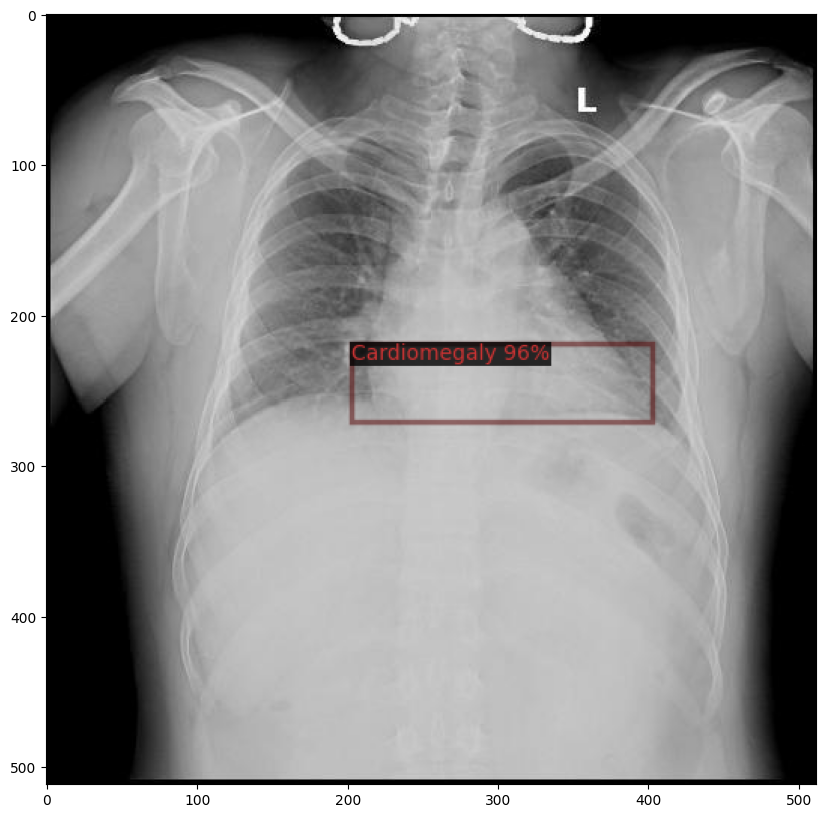

Detected 1 objects with confidence > 50.0%.


In [ ]:
# 🧠 Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "best_model.pth")  # Load the weights from your training
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold to 50% for detection

from detectron2.engine import DefaultPredictor

predictor = DefaultPredictor(cfg)

# 📸 Read the image
#image_path = '/content/valid/00000732_005_jpg.rf.3541c4c659fec2d5d003b4fb7a380dea.jpg'
image_path = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/test/9ed1f91369552618456da255b02820b3_jpg.rf.17cd671024249e0b1f3a9e36be41a928.jpg"
im = cv2.imread(image_path)

# 🧠 Run inference
outputs = predictor(im)

# Filter instances with confidence
confidence = 0.5
instances = outputs["instances"]
scores = instances.scores
filtered_instances = instances[scores > confidence]

# 🖼️ Visualize the results
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("roboflow_train"), scale=1)
v = v.draw_instance_predictions(filtered_instances.to("cpu"))

# Show the image with filtered instances
plt.figure(figsize=(10, 10))
plt.imshow(v.get_image())
plt.show()

# Optionally, print out the number of detections
print(f"Detected {len(filtered_instances)} objects with confidence > {confidence*100}%.")


# **Grafik Evaluasi Record Training**

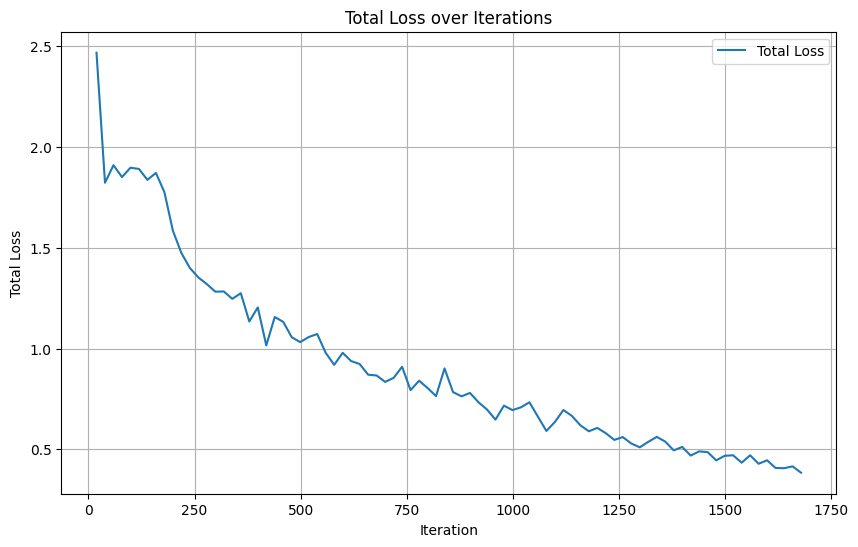

In [1]:
import json
import matplotlib.pyplot as plt

# Tentukan path ke file metrics.json
metrics_file = '/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/metrics.json'  # Ganti dengan path file Anda

# Menyaring data untuk total_loss
iterations = []
total_loss = []

# Membaca file JSON baris per baris
with open(metrics_file, 'r') as f:
    for line in f:
        # Memuat setiap baris JSON
        entry = json.loads(line)

        # Menyaring data untuk iteration dan total_loss
        if 'iteration' in entry and 'total_loss' in entry:
            iterations.append(entry['iteration'])
            total_loss.append(entry['total_loss'])

# Membuat grafik untuk total loss
plt.figure(figsize=(10, 6))
plt.plot(iterations, total_loss, label="Total Loss", color='tab:blue')

# Menambahkan judul dan label sumbu
plt.title('Total Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Total Loss')
plt.grid(True)

# Menampilkan grafik
plt.legend()
plt.show()

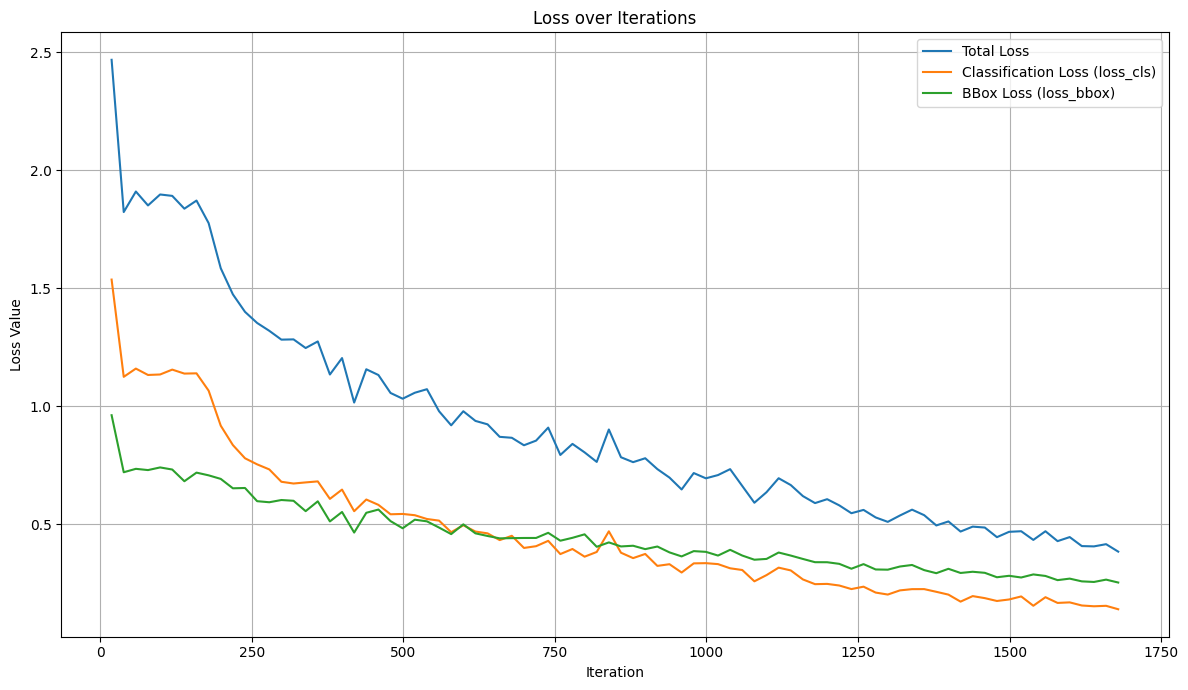

In [2]:
import json
import matplotlib.pyplot as plt

# Path ke file metrics.json
metrics_file = '/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/metrics.json'  # Ganti sesuai path Anda

# Inisialisasi list untuk menyimpan data
iterations = []
total_loss = []
loss_cls = []
loss_bbox = []

# Membaca dan memproses file JSON baris per baris
with open(metrics_file, 'r') as f:
    for line in f:
        entry = json.loads(line)

        if 'iteration' in entry:
            iterations.append(entry['iteration'])
            total_loss.append(entry.get('total_loss', None))
            loss_cls.append(entry.get('loss_cls', None))
            loss_bbox.append(entry.get('loss_box_reg', None))

# Membuat grafik
plt.figure(figsize=(12, 7))

plt.plot(iterations, total_loss, label='Total Loss', color='tab:blue')
plt.plot(iterations, loss_cls, label='Classification Loss (loss_cls)', color='tab:orange')
plt.plot(iterations, loss_bbox, label='BBox Loss (loss_bbox)', color='tab:green')

# Menambahkan elemen visual
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Menampilkan grafik
plt.show()


Total data points: 4


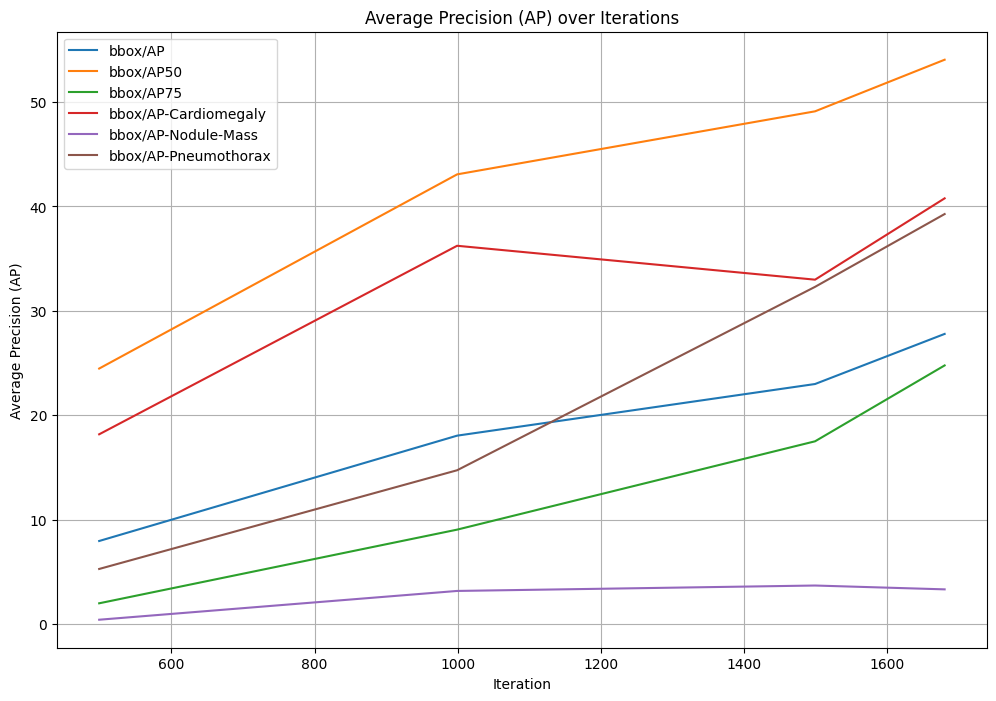

In [3]:
import json
import matplotlib.pyplot as plt

# Tentukan path ke file metrics.json
metrics_file = '/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/metrics.json'  # Ganti dengan path file Anda

# Menyaring data untuk AP
iterations = []
bbox_ap = []
bbox_ap50 = []
bbox_ap75 = []
bbox_ap_cardio = []
bbox_ap_nodule = []
bbox_ap_pneumo = []

# Membaca file JSON baris per baris
with open(metrics_file, 'r') as f:
    for line in f:
        try:
            entry = json.loads(line)

            # Pastikan hanya memasukkan data yang mengandung metrik 'bbox/AP'
            if 'bbox/AP' in entry:
                iterations.append(entry['iteration'])
                bbox_ap.append(entry['bbox/AP'])
                bbox_ap50.append(entry.get('bbox/AP50', None))
                bbox_ap75.append(entry.get('bbox/AP75', None))
                bbox_ap_cardio.append(entry.get('bbox/AP-Cardiomegaly', None))
                bbox_ap_nodule.append(entry.get('bbox/AP-Nodule-Mass', None))
                bbox_ap_pneumo.append(entry.get('bbox/AP-Pneumothorax', None))

        except json.JSONDecodeError as e:
            print(f"Error parsing line: {e}")
            continue

# Memastikan ada data untuk plotting
print(f"Total data points: {len(iterations)}")

# Jika ada data untuk plotting, buat grafik
if iterations:
    plt.figure(figsize=(12, 8))

    # Plotting berbagai metrik AP
    plt.plot(iterations, bbox_ap, label="bbox/AP", color='tab:blue')
    plt.plot(iterations, bbox_ap50, label="bbox/AP50", color='tab:orange')
    plt.plot(iterations, bbox_ap75, label="bbox/AP75", color='tab:green')
    plt.plot(iterations, bbox_ap_cardio, label="bbox/AP-Cardiomegaly", color='tab:red')
    plt.plot(iterations, bbox_ap_nodule, label="bbox/AP-Nodule-Mass", color='tab:purple')
    plt.plot(iterations, bbox_ap_pneumo, label="bbox/AP-Pneumothorax", color='tab:brown')

    # Menambahkan judul dan label sumbu
    plt.title('Average Precision (AP) over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Average Precision (AP)')
    plt.grid(True)

    # Menampilkan legenda
    plt.legend()

    # Menampilkan grafik
    plt.show()
else:
    print("Tidak ada data untuk plot.")


In [4]:
import json

# Menentukan path file metrics.json di Google Drive
file_path = '/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/metrics.json'

# Memuat file metrics.json
with open(file_path, 'r') as file:
    data = [json.loads(line) for line in file.readlines()]

# Menyaring nilai AP per kelas dari data terakhir
metrics = data[-1]  # Mengambil data terakhir yang berisi AP

# Mengambil nilai AP per kelas
ap_values = {
    "Cardiomegaly": metrics.get('bbox/AP-Cardiomegaly', 0),
    "Nodule-Mass": metrics.get('bbox/AP-Nodule-Mass', 0),
    "Pneumothorax": metrics.get('bbox/AP-Pneumothorax', 0),
}

# Menghitung mAP (mean Average Precision)
ap_values_list = list(ap_values.values())
map_score = sum(ap_values_list) / len(ap_values_list)

# Menampilkan hasil
print("AP per kelas:")
for class_name, ap in ap_values.items():
    print(f"{class_name}: {ap:.4f}")

print(f"\nmAP: {map_score:.4f}")


AP per kelas:
Cardiomegaly: 40.7780
Nodule-Mass: 3.3249
Pneumothorax: 39.2741

mAP: 27.7923


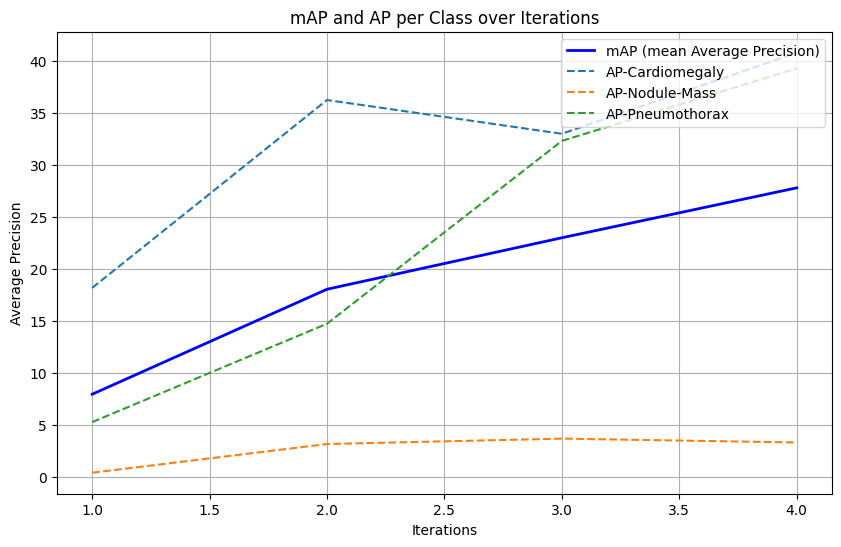

In [5]:
import json
import matplotlib.pyplot as plt

# Menentukan path file metrics.json (update dengan path yang sesuai)
file_path = '/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/metrics.json'

# Memuat file metrics.json
with open(file_path, 'r') as file:
    data = [json.loads(line) for line in file.readlines()]

# Menyaring nilai AP per kelas dari data terakhir
ap_per_iteration = []
map_per_iteration = []

# Menyaring nilai AP per kelas dan mAP dari setiap iterasi
for metrics in data:
    # Mengecek apakah nilai AP ada dalam data
    if 'bbox/AP-Cardiomegaly' in metrics and 'bbox/AP-Nodule-Mass' in metrics and 'bbox/AP-Pneumothorax' in metrics:
        ap_values = {
            "Cardiomegaly": metrics.get('bbox/AP-Cardiomegaly', 0),
            "Nodule-Mass": metrics.get('bbox/AP-Nodule-Mass', 0),
            "Pneumothorax": metrics.get('bbox/AP-Pneumothorax', 0),
        }

        # Menghitung mAP (mean Average Precision)
        ap_values_list = list(ap_values.values())
        map_score = sum(ap_values_list) / len(ap_values_list)

        ap_per_iteration.append(ap_values)
        map_per_iteration.append(map_score)

# Menyiapkan data untuk grafik
iterations = range(1, len(map_per_iteration) + 1)

# Plotting mAP per iterasi
plt.figure(figsize=(10, 6))
plt.plot(iterations, map_per_iteration, label='mAP (mean Average Precision)', color='blue', linewidth=2)

# Menambahkan grafik untuk setiap kelas
for class_name in ap_per_iteration[0].keys():
    class_ap_values = [ap[class_name] for ap in ap_per_iteration]
    plt.plot(iterations, class_ap_values, label=f'AP-{class_name}', linestyle='--')

# Menambahkan label dan judul
plt.xlabel('Iterations')
plt.ylabel('Average Precision')
plt.title('mAP and AP per Class over Iterations')
plt.legend(loc='upper right')

# Menampilkan grafik
plt.grid(True)
plt.show()


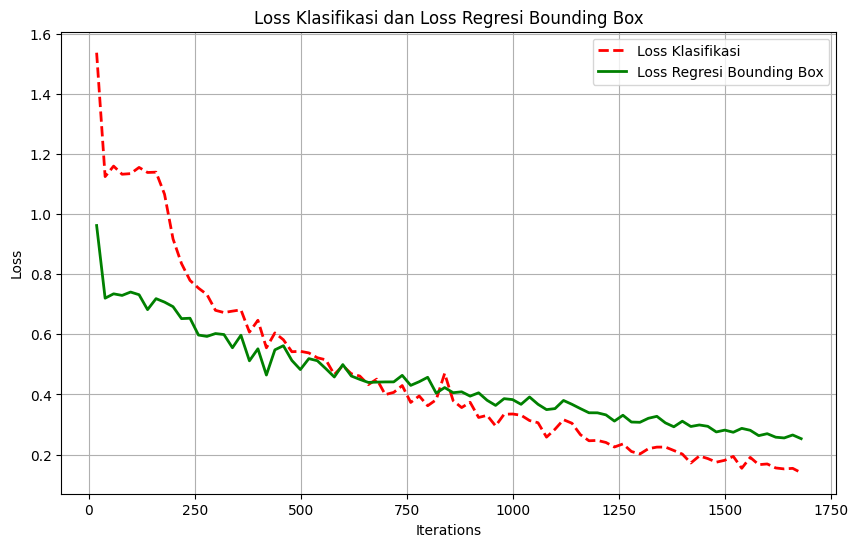

In [6]:
import matplotlib.pyplot as plt
import json

# Path file di Google Drive (sesuaikan dengan path file Anda)
file_path = '/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/metrics.json'

# Memuat data dari file metrics.json
with open(file_path, 'r') as f:
    data = [json.loads(line) for line in f]

# Menyiapkan data untuk plot
iterations = []
loss_cls_values = []
loss_box_reg_values = []

# Looping untuk mengekstrak data
for metrics in data:
    # Pastikan ada key yang dibutuhkan
    if 'iteration' in metrics:
        iterations.append(metrics['iteration'])
    if 'loss_cls' in metrics:
        loss_cls_values.append(metrics['loss_cls'])
    if 'loss_box_reg' in metrics:
        loss_box_reg_values.append(metrics['loss_box_reg'])

# Pastikan panjang data sama, dan jika tidak, sesuaikan panjangnya
min_len = min(len(iterations), len(loss_cls_values), len(loss_box_reg_values))

# Potong data agar memiliki panjang yang sama
iterations = iterations[:min_len]
loss_cls_values = loss_cls_values[:min_len]
loss_box_reg_values = loss_box_reg_values[:min_len]

# Membuat plot jika data ada
if iterations and loss_cls_values and loss_box_reg_values:
    plt.figure(figsize=(10, 6))

    # Plot Loss Klasifikasi
    plt.plot(iterations, loss_cls_values, label='Loss Klasifikasi', color='red', linestyle='--', linewidth=2)

    # Plot Loss Regresi Batas
    plt.plot(iterations, loss_box_reg_values, label='Loss Regresi Bounding Box', color='green', linestyle='-', linewidth=2)

    # Menambahkan label dan judul
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss Klasifikasi dan Loss Regresi Bounding Box')

    # Menambahkan legend
    plt.legend(loc='upper right')

    # Menampilkan grid
    plt.grid(True)

    # Menampilkan grafik
    plt.show()
else:
    print("Data tidak lengkap, pastikan key 'loss_cls' dan 'loss_box_reg' ada dalam setiap entri.")


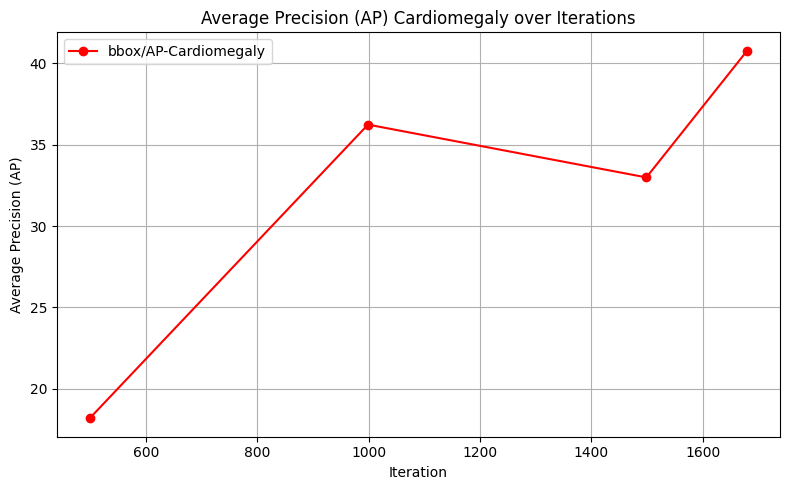

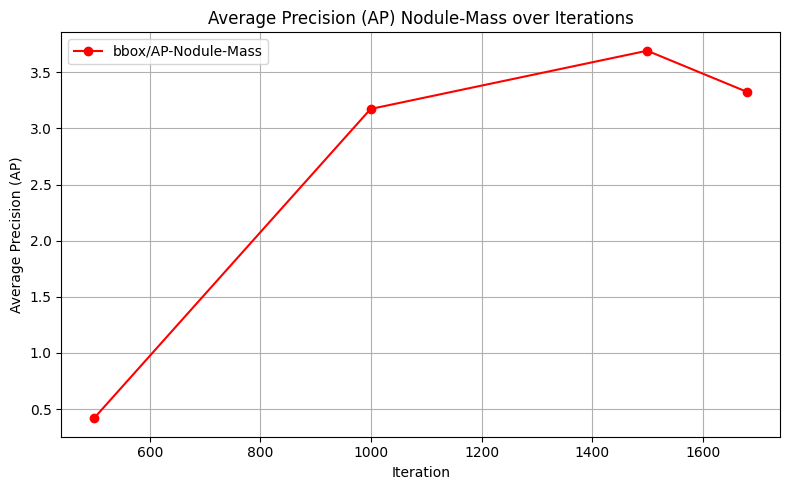

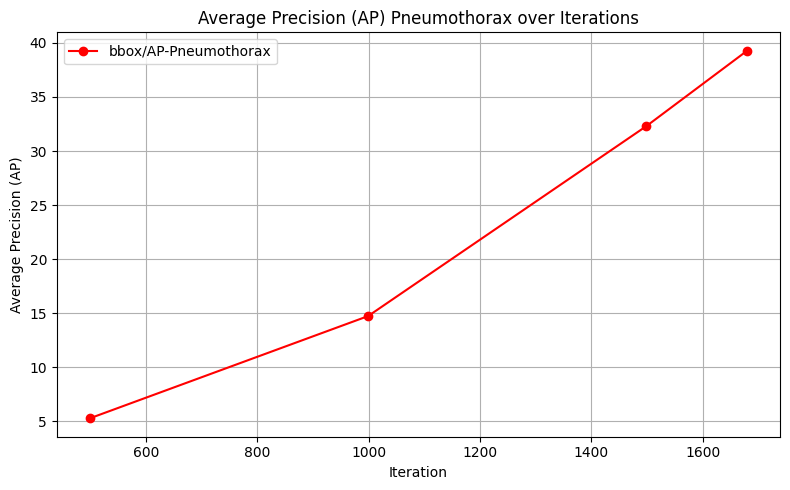

In [8]:
import json
import matplotlib.pyplot as plt

# Path file metrics.json
file_path = '/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_1e-5_Adam/metrics.json'

# Load file JSON
with open(file_path, 'r') as file:
    data = [json.loads(line) for line in file.readlines()]

# Menyimpan AP per kelas dan iterasi
ap_per_iteration = { "Cardiomegaly": [], "Nodule-Mass": [], "Pneumothorax": [] }
iteration_list = []

# Ekstraksi AP dan iterasi
for metrics in data:
    if all(k in metrics for k in ['bbox/AP-Cardiomegaly', 'bbox/AP-Nodule-Mass', 'bbox/AP-Pneumothorax']):
        iteration = metrics.get("iteration", None)
        if iteration is not None:
            iteration_list.append(iteration)
            ap_per_iteration["Cardiomegaly"].append(metrics['bbox/AP-Cardiomegaly'])
            ap_per_iteration["Nodule-Mass"].append(metrics['bbox/AP-Nodule-Mass'])
            ap_per_iteration["Pneumothorax"].append(metrics['bbox/AP-Pneumothorax'])

# Plot untuk setiap kelas
for class_name, ap_values in ap_per_iteration.items():
    plt.figure(figsize=(8, 5))
    plt.plot(iteration_list, ap_values, marker='o', color='red', label=f'bbox/AP-{class_name}')
    plt.xlabel('Iteration')
    plt.ylabel('Average Precision (AP)')
    plt.title(f'Average Precision (AP) {class_name} over Iterations')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# **Confusion Matrix**

In [ ]:
def calculate_iou(box1, box2):
    """
    box: [xmin, ymin, xmax, ymax]
    """
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    if union_area == 0:
        return 0
    else:
        return inter_area / union_area


[06/14 15:41:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/best_model.pth ...


Processing Test Images: 100%|██████████| 111/111 [00:11<00:00, 10.01it/s]


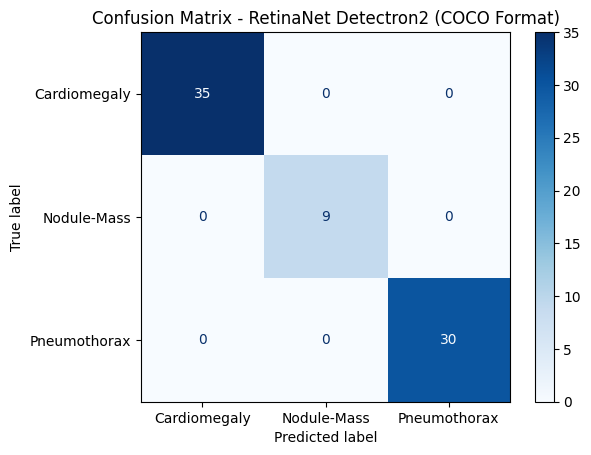

In [ ]:
import os
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 🧠 Load model
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "best_model.pth")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/best_model.pth"
predictor = DefaultPredictor(cfg)

# 📚 Prepare dataset paths
test_image_dir = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test"
coco_annotation_path = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test/_annotations.coco.json"

# Load COCO ground truth
with open(coco_annotation_path) as f:
    coco_data = json.load(f)

# Build image_id to filename mapping
id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}

# Build annotations mapping
annotations = coco_data['annotations']
gt_dict = {}  # {filename: (boxes, labels)}

for ann in annotations:
    image_id = ann['image_id']
    filename = id_to_filename[image_id]
    bbox = ann['bbox']  # [x, y, width, height]
    category_id = ann['category_id']

    if filename not in gt_dict:
        gt_dict[filename] = {'boxes': [], 'labels': []}

    # Convert bbox format to [xmin, ymin, xmax, ymax]
    xmin, ymin, w, h = bbox
    xmax = xmin + w
    ymax = ymin + h

    gt_dict[filename]['boxes'].append([xmin, ymin, xmax, ymax])
    gt_dict[filename]['labels'].append(category_id)

# Build category_id to class_name mapping
category_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
class_names = [category_id_to_name[i] for i in sorted(category_id_to_name.keys())]

# 🔥 Start evaluating
y_true = []
y_pred = []
iou_threshold = 0.5
confidence_threshold = 0.5

test_images = sorted(os.listdir(test_image_dir))
test_images = [img for img in test_images if img.endswith('.jpg') or img.endswith('.png')]

for img_file in tqdm(test_images, desc="Processing Test Images"):
    # Read image
    img_path = os.path.join(test_image_dir, img_file)
    img = cv2.imread(img_path)

    if img_file not in gt_dict:
        continue  # skip images without ground truth

    gt_boxes = np.array(gt_dict[img_file]['boxes'])
    gt_classes = np.array(gt_dict[img_file]['labels'])

    # Predict
    outputs = predictor(img)
    instances = outputs["instances"].to("cpu")

    pred_boxes = instances.pred_boxes.tensor.numpy()
    pred_classes = instances.pred_classes.numpy()
    pred_scores = instances.scores.numpy()

    # Filter predictions by confidence
    keep = pred_scores > confidence_threshold
    pred_boxes = pred_boxes[keep]
    pred_classes = pred_classes[keep]

    matched_gt = set()

    # Matching predicted boxes to ground truth boxes
    for pred_box, pred_class in zip(pred_boxes, pred_classes):
        best_iou = 0
        best_idx = -1
        for idx, gt_box in enumerate(gt_boxes):
            iou = calculate_iou(pred_box, gt_box)
            if iou > best_iou and idx not in matched_gt:
                best_iou = iou
                best_idx = idx
        if best_iou >= iou_threshold and best_idx != -1:
            y_true.append(gt_classes[best_idx])
            y_pred.append(pred_class)
            matched_gt.add(best_idx)
        else:
            # False positive
            y_true.append(-1)  # background
            y_pred.append(pred_class)

    # False negatives
    for idx, gt_class in enumerate(gt_classes):
        if idx not in matched_gt:
            y_true.append(gt_class)
            y_pred.append(-1)

# 🔥 Build Confusion Matrix
all_labels = sorted(list(set([lab for lab in y_true if lab != -1] + [lab for lab in y_pred if lab != -1])))
cm = confusion_matrix(y_true, y_pred, labels=all_labels)

class_labels = [category_id_to_name[i] for i in all_labels]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - RetinaNet Detectron2 (COCO Format)")
plt.show()


# **Evaluasi Data Train, Validasi, dan Testing**

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

# Load config dan model
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/config.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/best_model.pth"
cfg.MODEL.DEVICE = 'cpu'  # atau 'cpu'
cfg.DATASETS.TEST = ("roboflow_train",)
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

evaluator = COCOEvaluator("roboflow_train", cfg, False, output_dir="/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/eval_train")
val_loader = build_detection_test_loader(cfg, "roboflow_train")

model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

results = inference_on_dataset(model, val_loader, evaluator)
print(results)

WARNING [06/14 15:42:19 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [06/14 15:42:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 15:42:19 d2.data.datasets.coco]: Loaded 892 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/train/_annotations.coco.json
[06/14 15:42:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/14 15:42:19 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/14 15:42:19 d2.data.common]: Serializing 892 elements to byte tensors and concatenating them all ...
[06/14 15:42:19 d2.data.common]: Serialized dataset takes 0.30 MiB


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/14 15:42:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/best_model.pth ...
[06/14 15:42:21 d2.evaluation.evaluator]: Start inference on 892 batches
[06/14 15:43:05 d2.evaluation.evaluator]: Inference done 11/892. Dataloading: 0.0011 s/iter. Inference: 4.1184 s/iter. Eval: 0.0002 s/iter. Total: 4.1196 s/iter. ETA=1:00:29
[06/14 15:43:13 d2.evaluation.evaluator]: Inference done 13/892. Dataloading: 0.0012 s/iter. Inference: 4.0129 s/iter. Eval: 0.0002 s/iter. Total: 4.0146 s/iter. ETA=0:58:48
[06/14 15:43:21 d2.evaluation.evaluator]: Inference done 15/892. Dataloading: 0.0013 s/iter. Inference: 4.0358 s/iter. Eval: 0.0002 s/iter. Total: 4.0378 s/iter. ETA=0:59:01
[06/14 15:43:30 d2.evaluation.evaluator]: Inference done 17/892. Dataloading: 0.0015 s/iter. Inference: 4.0645 s/iter. Eval: 0.0002 s/iter. Total: 4.0666 s/iter. ETA=0:59:18
[06/14 15:43:37 d2.evaluation.e

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

# Load config dan model
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/config.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/best_model.pth"
cfg.MODEL.DEVICE = 'cpu'  # atau 'cpu'
cfg.DATASETS.TEST = ("roboflow_val",)
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

evaluator = COCOEvaluator("roboflow_val", cfg, False, output_dir="/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/eval_valid")
val_loader = build_detection_test_loader(cfg, "roboflow_val")

model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

results = inference_on_dataset(model, val_loader, evaluator)
print(results)

WARNING [06/14 16:44:23 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [06/14 16:44:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 16:44:23 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/valid/_annotations.coco.json
[06/14 16:44:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/14 16:44:23 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/14 16:44:23 d2.data.common]: Serializing 111 elements to byte tensors and concatenating them all ...
[06/14 16:44:23 d2.data.common]: Serialized dataset takes 0.04 MiB


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/14 16:44:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/best_model.pth ...
[06/14 16:44:24 d2.evaluation.evaluator]: Start inference on 111 batches
[06/14 16:45:10 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0012 s/iter. Inference: 4.1959 s/iter. Eval: 0.0002 s/iter. Total: 4.1973 s/iter. ETA=0:06:59
[06/14 16:45:19 d2.evaluation.evaluator]: Inference done 13/111. Dataloading: 0.0014 s/iter. Inference: 4.2670 s/iter. Eval: 0.0002 s/iter. Total: 4.2689 s/iter. ETA=0:06:58
[06/14 16:45:26 d2.evaluation.evaluator]: Inference done 15/111. Dataloading: 0.0015 s/iter. Inference: 4.1589 s/iter. Eval: 0.0002 s/iter. Total: 4.1609 s/iter. ETA=0:06:39
[06/14 16:45:35 d2.evaluation.evaluator]: Inference done 17/111. Dataloading: 0.0016 s/iter. Inference: 4.1910 s/iter. Eval: 0.0002 s/iter. Total: 4.1931 s/iter. ETA=0:06:34
[06/14 16:45:43 d2.evaluation.e

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

# Load config dan model
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/config.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/best_model.pth"
cfg.MODEL.DEVICE = 'cpu'  # atau 'cpu'
cfg.DATASETS.TEST = ("roboflow_test",)
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

evaluator = COCOEvaluator("roboflow_test", cfg, False, output_dir="/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/eval_test")
val_loader = build_detection_test_loader(cfg, "roboflow_test")

model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

results = inference_on_dataset(model, val_loader, evaluator)
print(results)

WARNING [06/14 16:52:19 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [06/14 16:52:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 16:52:20 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test/_annotations.coco.json
[06/14 16:52:20 d2.data.build]: Distribution of instances among all 4 categories:
|   category    | #instances   |   category   | #instances   |  category   | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-----------:|:-------------|
| abnormalities | 0            | Cardiomegaly | 36           | Nodule-Mass | 34           |
| Pneumothorax  | 40           |              |              |             |              |
|     total     | 110          |              |       

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/14 16:52:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_30_5e-5_Adam/best_model.pth ...
[06/14 16:52:20 d2.evaluation.evaluator]: Start inference on 111 batches
[06/14 16:53:05 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0028 s/iter. Inference: 3.8270 s/iter. Eval: 0.0002 s/iter. Total: 3.8300 s/iter. ETA=0:06:22
[06/14 16:53:13 d2.evaluation.evaluator]: Inference done 13/111. Dataloading: 0.0025 s/iter. Inference: 3.9397 s/iter. Eval: 0.0002 s/iter. Total: 3.9426 s/iter. ETA=0:06:26
[06/14 16:53:22 d2.evaluation.evaluator]: Inference done 15/111. Dataloading: 0.0024 s/iter. Inference: 4.0023 s/iter. Eval: 0.0002 s/iter. Total: 4.0052 s/iter. ETA=0:06:24
[06/14 16:53:29 d2.evaluation.evaluator]: Inference done 17/111. Dataloading: 0.0024 s/iter. Inference: 3.9707 s/iter. Eval: 0.0002 s/iter. Total: 3.9736 s/iter. ETA=0:06:13
[06/14 16:53:38 d2.evaluation.e

In [ ]:
from detectron2.evaluation.evaluator import DatasetEvaluator
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

class PRF1Evaluator(DatasetEvaluator):
    def __init__(self, dataset_name, metadata, class_names=None):
        from detectron2.data import MetadataCatalog, DatasetCatalog
        self.metadata = MetadataCatalog.get(dataset_name)
        self.dataset_dicts = DatasetCatalog.get(dataset_name)
        self.class_names = class_names if class_names else self.metadata.thing_classes
        self.gts = []
        self.preds = []

        # Buat mapping image_id ke daftar ground truth class ID
        self.imgid_to_gt = {}
        for data in self.dataset_dicts:
            gt_classes = [ann["category_id"] for ann in data["annotations"]]
            self.imgid_to_gt[data["image_id"]] = gt_classes

    def reset(self):
        self.gts = []
        self.preds = []

    def process(self, inputs, outputs):
        for input, output in zip(inputs, outputs):
            img_id = input["image_id"]
            gt_classes = self.imgid_to_gt.get(img_id, [])
            pred_classes = output["instances"].pred_classes.cpu().numpy() if len(output["instances"]) > 0 else []

            # Samakan panjang prediksi dan ground truth
            if len(pred_classes) < len(gt_classes):
                pred_classes = list(pred_classes) + [-1] * (len(gt_classes) - len(pred_classes))
            elif len(pred_classes) > len(gt_classes):
                pred_classes = pred_classes[:len(gt_classes)]

            self.gts.extend(gt_classes)
            self.preds.extend(pred_classes)

    def evaluate(self):
        print("\n==== Precision, Recall, and F1-Score per Class ====\n")

        # Ambil hasil sebagai dictionary
        report_dict = classification_report(
            self.gts,
            self.preds,
            target_names=self.class_names,
            output_dict=True,
            digits=3,
            zero_division=0
        )

        # Konversi ke DataFrame
        df = pd.DataFrame(report_dict).transpose()
        df.index.name = 'Class'

        # Ambil dan simpan nilai akurasi, hapus dari tabel supaya tampil rapi
        accuracy = report_dict.get("accuracy", None)
        if "accuracy" in df.index:
            df.drop("accuracy", inplace=True)

        # Ubah support menjadi integer
        if 'support' in df.columns:
            df['support'] = df['support'].astype(int)

        # Urutkan kolom
        df = df[['precision', 'recall', 'f1-score', 'support']]

        # Cetak tabel
        print(df.to_string(float_format="%.3f"))

        # Cetak akurasi secara terpisah
        if accuracy is not None:
            print(f"\nOverall Accuracy: {accuracy:.3f}")

        # Return hanya data, tanpa tampilkan dict sebagai output Python
        return


In [ ]:
class_names = ["Cardiomegaly", "Nodule/Mass", "Pneumothorax"]

evaluator_test = PRF1Evaluator("roboflow_train", cfg, class_names=class_names)
test_loader = build_detection_test_loader(cfg, "roboflow_train")
inference_on_dataset(trainer.model, test_loader, evaluator_test)


WARNING [06/14 17:00:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 17:00:28 d2.data.datasets.coco]: Loaded 892 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/train/_annotations.coco.json
WARNING [06/14 17:00:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 17:00:28 d2.data.datasets.coco]: Loaded 892 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/train/_annotations.coco.json
[06/14 17:00:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/14 17:00:28 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/14 17:00:28 d2.data.common]: Serializing 892 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/14 17:00:29 d2.evaluation.evaluator]: Inference done 11/892. Dataloading: 0.0009 s/iter. Inference: 0.0723 s/iter. Eval: 0.0001 s/iter. Total: 0.0733 s/iter. ETA=0:01:04
[06/14 17:00:34 d2.evaluation.evaluator]: Inference done 72/892. Dataloading: 0.0034 s/iter. Inference: 0.0778 s/iter. Eval: 0.0001 s/iter. Total: 0.0815 s/iter. ETA=0:01:06
[06/14 17:00:39 d2.evaluation.evaluator]: Inference done 124/892. Dataloading: 0.0042 s/iter. Inference: 0.0841 s/iter. Eval: 0.0001 s/iter. Total: 0.0885 s/iter. ETA=0:01:07
[06/14 17:00:44 d2.evaluation.evaluator]: Inference done 173/892. Dataloading: 0.0048 s/iter. Inference: 0.0878 s/iter. Eval: 0.0002 s/iter. Total: 0.0929 s/iter. ETA=0:01:06
[06/14 17:00:50 d2.evaluation.evaluator]: Inference done 235/892. Dataloading: 0.0041 s/iter. Inference: 0.0855 s/iter. Eval: 0.0002 s/iter. Total: 0.0899 s/iter. ETA=0:00:59
[06/14 17:00:55 d2.evaluation.evaluator]: Inference done 300/892. Dataloading: 0.0035 s/iter. Inference: 0.0835 s/iter. Eval: 0

{}

In [ ]:
class_names = ["Cardiomegaly", "Nodule/Mass", "Pneumothorax"]

evaluator_test = PRF1Evaluator("roboflow_val", cfg, class_names=class_names)
test_loader = build_detection_test_loader(cfg, "roboflow_val")
inference_on_dataset(trainer.model, test_loader, evaluator_test)

WARNING [06/14 17:02:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 17:02:13 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/valid/_annotations.coco.json
WARNING [06/14 17:02:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 17:02:13 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/valid/_annotations.coco.json
[06/14 17:02:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/14 17:02:13 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/14 17:02:13 d2.data.common]: Serializing 111 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/14 17:02:14 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0013 s/iter. Inference: 0.0763 s/iter. Eval: 0.0001 s/iter. Total: 0.0777 s/iter. ETA=0:00:07
[06/14 17:02:20 d2.evaluation.evaluator]: Inference done 76/111. Dataloading: 0.0021 s/iter. Inference: 0.0749 s/iter. Eval: 0.0001 s/iter. Total: 0.0772 s/iter. ETA=0:00:02
[06/14 17:02:22 d2.evaluation.evaluator]: Total inference time: 0:00:08.217298 (0.077522 s / iter per device, on 1 devices)
[06/14 17:02:22 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.074547 s / iter per device, on 1 devices)

==== Precision, Recall, and F1-Score per Class ====

              precision  recall  f1-score  support
Class                                             
Cardiomegaly      0.658   0.962     0.781       26
Nodule/Mass       0.944   0.607     0.739       28
Pneumothorax      0.964   0.930     0.946       57
macro avg         0.855   0.833     0.822      111
weighted avg      0.887   0.856     0.

{}

In [ ]:
class_names = ["Cardiomegaly", "Nodule/Mass", "Pneumothorax"]

evaluator_test = PRF1Evaluator("roboflow_test", cfg, class_names=class_names)
test_loader = build_detection_test_loader(cfg, "roboflow_test")
inference_on_dataset(trainer.model, test_loader, evaluator_test)

WARNING [06/14 17:03:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 17:03:04 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test/_annotations.coco.json
WARNING [06/14 17:03:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 17:03:04 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test/_annotations.coco.json
[06/14 17:03:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/14 17:03:04 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/14 17:03:04 d2.data.common]: Serializing 111 el

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/14 17:03:06 d2.evaluation.evaluator]: Inference done 11/111. Dataloading: 0.0010 s/iter. Inference: 0.0744 s/iter. Eval: 0.0001 s/iter. Total: 0.0755 s/iter. ETA=0:00:07
[06/14 17:03:11 d2.evaluation.evaluator]: Inference done 77/111. Dataloading: 0.0016 s/iter. Inference: 0.0744 s/iter. Eval: 0.0001 s/iter. Total: 0.0762 s/iter. ETA=0:00:02
[06/14 17:03:13 d2.evaluation.evaluator]: Total inference time: 0:00:08.281174 (0.078124 s / iter per device, on 1 devices)
[06/14 17:03:13 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.074837 s / iter per device, on 1 devices)

==== Precision, Recall, and F1-Score per Class ====

              precision  recall  f1-score  support
Class                                             
Cardiomegaly      0.778   0.972     0.864       36
Nodule/Mass       0.926   0.735     0.820       34
Pneumothorax      0.947   0.900     0.923       40
macro avg         0.884   0.869     0.869      110
weighted avg      0.885   0.873     0.

{}